In [56]:
from os.path import join, exists
from glob import glob

import numpy as np
import pandas as pd

from tqdm import tqdm

import json

from PIL import Image, ImageFilter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, IndexLocator, FuncFormatter
from nilearn import image, plotting, masking

In [2]:
# from core.env import mlagent

In [3]:
import torch

# device = "cuda:1" if torch.cuda.is_available() else "cpu"
device = 'cpu'
device

'cpu'

In [4]:
scaler = StandardScaler()

In [5]:
dir_root = '/mnt/ext5/DRN'
dir_behav = join(dir_root, 'behav_data')
dir_fmri = join(dir_root,'fmri_data')
dir_mask = join(dir_fmri, 'masks')
dir_model = join(dir_root,'model')

---

In [6]:
def state_processing(obs):
    vis_obs = []

    for _obs in obs:
        ## _obs.shape = (1, 72, 128, 3)
        vis_obs.append(_obs)

    ## visual observation [(1, 72, 128, 3) x 4]
    vis_obs = np.concatenate(vis_obs, axis=-1)
    ## visual observation (1, 72, 128, 12)
    vis_obs = np.transpose(vis_obs, (0, 3, 1, 2))
    vis_obs = (vis_obs * 255).astype(np.uint8)
    
    ## visual observation (1, 12, 72, 128)
    return vis_obs

In [7]:
def convert_time_to_sec(Time):
    m, s, ds = np.array(Time.split('-')).astype(int)
    return m*60+s+0.001*ds

---

In [8]:
## time points per a run
TR = 0.5
TPs = 1400 - 12

In [9]:
subj = 'DRN04'

---

### behavioral data

1. screen captures

In [10]:
from torchvision import transforms

convert_tensor = transforms.ToTensor()

In [11]:
resolution = (128,72)

In [12]:
dir_behav = '/mnt/ext5/DRN/behav_data/%s'%subj
dir_resize = join(dir_behav,'resized_%dx%d'%(resolution[0],resolution[1]))

In [13]:
list_png = {}
for run in ['Run%d'%(ii+1) for ii in range(6)]:
    list_png[run] = np.array(sorted(glob(join(dir_resize,run,'*.png'))))
    print(len(list_png[run]))

6381
6401
6416
6367
6375
6375


(72, 128, 3)

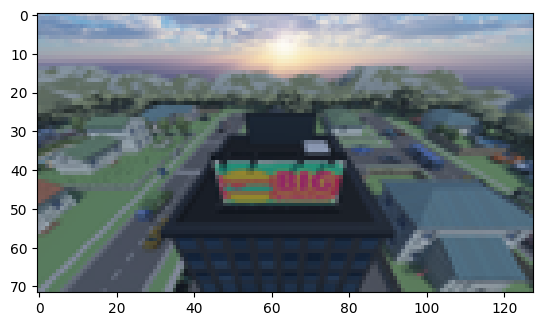

In [14]:
img = Image.open(list_png['Run1'][0])
plt.imshow(img)
np.asarray(img).shape

2. actions

In [15]:
behav = {}
for run in ['Run%d'%(ii+1) for ii in range(6)]:
    with open(join(dir_behav,run,'log.json'),'r') as f:
        behav[run] = json.load(f)
    print('%s: actions (%d) / pngs (%d)'%(run, len(behav[run]), len(list_png[run])))

Run1: actions (6381) / pngs (6381)
Run2: actions (6401) / pngs (6401)
Run3: actions (6416) / pngs (6416)
Run4: actions (6367) / pngs (6367)
Run5: actions (6375) / pngs (6375)
Run6: actions (6375) / pngs (6375)


In [16]:
list_onsettime = {}
list_episode = {}
for run in ['Run%d'%(ii+1) for ii in range(6)]:
    tmp = []
    tmp2 = []
    for dict_ in behav[run]:
        ## onset time
        onsettime = convert_time_to_sec(dict_['Time'])
        tmp.append(onsettime)
        ## episode
        tmp2.append(dict_['Episode'])
    list_onsettime[run] = np.array(tmp)
    list_episode[run] = np.array(tmp2)

In [17]:
list_onsettime

{'Run1': array([  6.051,   6.125,   6.229, ..., 699.727, 699.825, 699.929]),
 'Run2': array([  6.044,   6.076,   6.18 , ..., 700.764, 700.861, 700.965]),
 'Run3': array([  6.052,   6.069,   6.167, ..., 700.787, 700.892, 700.989]),
 'Run4': array([  6.05 ,   6.104,   6.201, ..., 700.768, 700.873, 700.97 ]),
 'Run5': array([  6.056,   6.083,   6.18 , ..., 700.719, 700.823, 700.92 ]),
 'Run6': array([  6.045,   6.076,   6.173, ..., 700.435, 700.539, 700.637])}

In [18]:
np.where(np.diff(list_episode['Run1']))

(array([ 138,  257,  345,  411,  753,  846,  903,  998, 1110, 1179, 1267,
        1386, 1465, 1543, 1677, 1765, 1838, 1908, 1983, 2058, 2122, 2234,
        2311, 2440, 2529, 2593, 2707, 2812, 2897, 2959, 3019, 3090, 3224,
        3361, 3444, 3573, 3686, 3779, 3875, 3948, 4018, 4124, 4207, 4286,
        4360, 4417, 4502, 4591, 4690, 4793, 4850, 4970, 5054, 5142, 5241,
        5385, 5507, 5608, 5704, 5785, 5864, 6019, 6163, 6262]),)

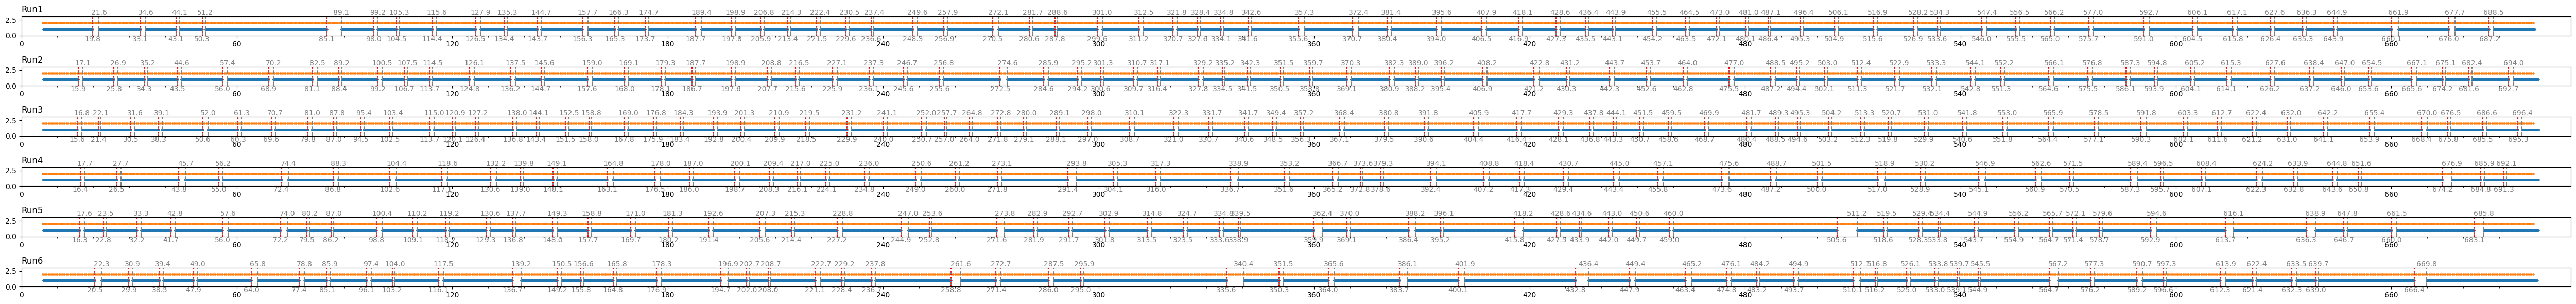

In [19]:
fig, axs = plt.subplots(nrows=6, figsize=(50,6))

for ii, run in enumerate(['Run%1d'%(rr+1) for rr in range(6)]):
    ax = axs[ii]
    
    ## frames
    x = list_onsettime[run]
    y = np.ones(len(x))
    ax.scatter(x,y,s=10,linewidths=0.1)
    ax.set_xlim(0,710)
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    
    idx_gap = np.where(np.diff(x)>0.4)[0]
    for idx in idx_gap:
        ax.vlines(x=x[idx], ymin=0, ymax=3, color='gray', linestyle='--')
        ax.text(
            x[idx], 0, '%.1f'%x[idx],
            va='top', ha='center',
            color='gray'
        )
        ax.vlines(x=x[idx+1], ymin=0, ymax=3, color='gray', linestyle='--')
        ax.text(
            x[idx+1], 3, '%.1f'%x[idx+1],
            va='bottom', ha='center',
            color='gray'
        )

    ## episode
    idx_end = np.where(np.diff(list_episode[run]))
    for idx in idx_end:
        ax.vlines(x=x[idx], ymin=0, ymax=3, color='red', linestyle=':')

    ## fMRI
    ax.scatter(np.arange(6,700,0.5),2*np.ones(TPs),s=10,linewidths=0.1)
    ax.set_ylim(0,3)
    
    ax.set_title(run, loc='left')

fig.tight_layout()

---

In [20]:
def get_idx_input(run, shift=0):
    nFrameStack = 4
    TR = 0.5

    onsettimes = list_onsettime[run]
    onsettimes = onsettimes[onsettimes<700-shift]

    ## A set of the last indices for each episode except the last episode
    idx_final = np.concatenate([np.where(np.diff(onsettimes)>TR)[0], [onsettimes.shape[0]-1]])
    idx_initial = np.concatenate([[0],idx_final[:-1]+1])
    assert idx_initial.shape == idx_final.shape

    idx_input = {}
    idx_epi = {}
    for ii, (idx_i, idx_f) in enumerate(zip(idx_initial, idx_final)):
        episode = 'episode:%02d'%(ii+1)

        ## the times of the initial and final frame
        ta, tb = onsettimes[idx_i], onsettimes[idx_f]
        ## the number of frames at the episode
        n_frame = int(idx_f-idx_i+1)

        ## The fMRI image corresponding to the first frame of this episode
        a = ta - ta%TR
        ## The fMRI image corresponding to the final frame of this episode
        b = tb - tb%TR

        ## The number of fMRI images representing the corresponding episode.
        n_epi = int((b-a)/TR + 1)
        if n_epi <= 1:
            continue

        ## The fMRI indices that make up each episode
        timepoint_epi = np.arange(a,b+TR,TR)+shift
        timepoint_epi = timepoint_epi[timepoint_epi<700]
        idx_epi[episode] = (2*(timepoint_epi-6)).astype(int)

        ## an input set to forward via a model
        idx_input[episode] = np.zeros((n_epi,nFrameStack)).astype(int)

        ## the last input
        idx_input[episode][-1] = [idx_f-nFrameStack+1+jj for jj in range(nFrameStack)]

        ## the rest of them
        didx = (idx_f-nFrameStack-idx_i)*TR/(b-a+1.e-8)
        for jj in range(n_epi-1):
            idx_input[episode][jj] = [int(idx_i+didx*jj+kk) for kk in range(nFrameStack)]

    for episode, input_ in idx_input.items():
        assert input_.shape[0] == idx_epi[episode].shape[0]
    
    return idx_input, idx_epi

---

In [21]:
def plot_episode(run, shift):
    idx_input, idx_epi = get_idx_input(run=run, shift=shift)

    fig, ax = plt.subplots(nrows=1, figsize=(50,2))

    ax.vlines(x=6, ymin=0, ymax=3, color='black', linestyle='--')
    ax.text(
        6, 0, '%.1f'%6,
        va='top', ha='center',
        color='gray'
    )
    for epi, idx2Dset in idx_input.items():
        list_idx = idx2Dset.reshape(-1)

        ## frames
        x = list_onsettime[run][list_idx]
        y = np.ones(len(x))
        ax.scatter(x,y,s=10,linewidths=0.1)

        ax.vlines(x=x[-1], ymin=0, ymax=1, color='gray', linestyle='--')
        ax.text(
            x[-1], 0, '%.1f'%x[-1],
            va='top', ha='center',
            color='gray'
        )

        ## fMRI
        x = np.arange(6,700+shift,0.5)[idx_epi[epi]]
        y = np.ones(len(x))*2
        ax.scatter(x,y,s=10,linewidths=0.1)

        ax.vlines(x=x[-1], ymin=2, ymax=3, color='gray', linestyle='--')
        ax.text(
            x[-1], 3, '%.1f'%x[-1],
            va='bottom', ha='center',
            color='gray'
        )

    ax.set_xlim(0,710)
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.set_ylim(0,3)

    ax.set_title('%s (%.1fs shifted)'%(run,shift), loc='left')

    fig.tight_layout()

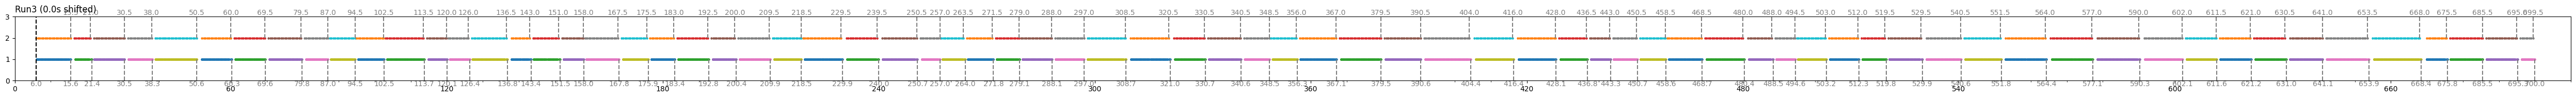

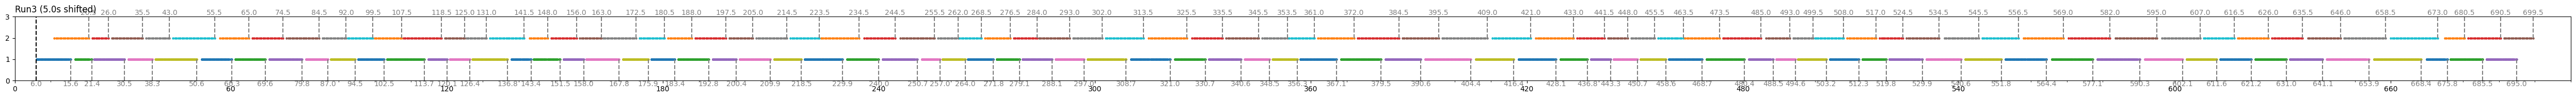

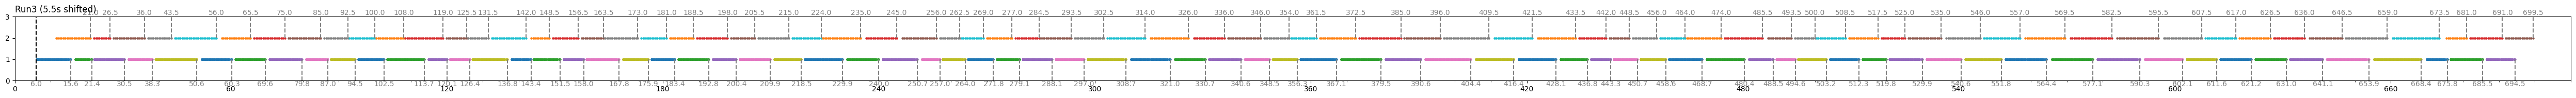

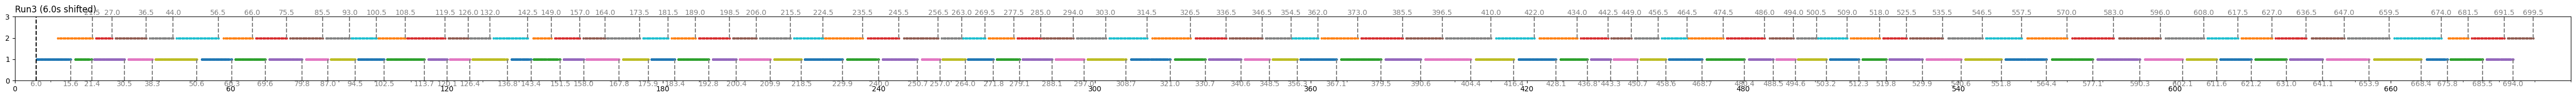

In [22]:
run = 'Run3'
for shift in [0, 5, 5.5, 6]:
    plot_episode(run,shift)

---

the config

In [23]:
with open(join(dir_model,'drone_hanyang_mlagent.ppo/drone_hanyang_mlagent.json'),'r') as f:
    hanyang = json.load(f)
hanyang

{'env': {'name': 'drone_hanyang_mlagent', 'render': 'True', 'time_scale': 3.0},
 'agent': {'name': 'ppo',
  'network': 'continuous_policy_value',
  'head': 'cnn',
  'gamma': 0.95,
  'batch_size': 32,
  'n_step': 128,
  'n_epoch': 3,
  '_lambda': 0.95,
  'epsilon_clip': 0.1,
  'vf_coef': 1.0,
  'ent_coef': 0.01,
  'clip_grad_norm': 1.0,
  'use_standardization': 'True',
  'lr_decay': 'False'},
 'optim': {'name': 'adam', 'lr': 0.00025},
 'train': {'training': 'True',
  'load_path': './logs/drone_hanyang_mlagent/ppo/20230311094756544355/',
  'run_step': 30000000,
  'print_period': 10000,
  'save_period': 500000,
  'eval_iteration': 3,
  'record': 'False',
  'record_period': 1000000,
  'distributed_batch_size': 256,
  'update_period': "agent['n_step']",
  'num_workers': 5}}

## load pretrained parameters

In [24]:
ckpt = torch.load(
    join(dir_model,'drone_hanyang_mlagent.ppo/level2.ckpt')
    , map_location=device
)

In [25]:
for key1, dict_ in ckpt.items():
    print('################')
    print(key1)
    print('################')
    for key2, value in dict_.items():
        if type(value) is not dict:
            print('%s\n%s\n'%(key2,value.shape))
        else:
            break

################
network
################
head.conv1.weight
torch.Size([32, 12, 8, 8])

head.conv1.bias
torch.Size([32])

head.conv2.weight
torch.Size([64, 32, 4, 4])

head.conv2.bias
torch.Size([64])

head.conv3.weight
torch.Size([64, 64, 3, 3])

head.conv3.bias
torch.Size([64])

l.weight
torch.Size([512, 3840])

l.bias
torch.Size([512])

mu.weight
torch.Size([3, 512])

mu.bias
torch.Size([3])

log_std.weight
torch.Size([3, 512])

log_std.bias
torch.Size([3])

v.weight
torch.Size([1, 512])

v.bias
torch.Size([1])

################
optimizer
################


---

# Encoding model

#### Network

In [26]:
from core.network import *

InputShape = (12,72,128)
network = policy_value.ContinuousPolicyValue(D_in=InputShape, D_out=3, D_hidden=512, head='cnn')
network.eval().to(device)

ContinuousPolicyValue(
  (head): CNN(
    (conv1): Conv2d(12, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (l): Linear(in_features=3840, out_features=512, bias=True)
  (mu): Linear(in_features=512, out_features=3, bias=True)
  (log_std): Linear(in_features=512, out_features=3, bias=True)
  (v): Linear(in_features=512, out_features=1, bias=True)
)

In [27]:
input_ = torch.rand((5,*InputShape))
print(input_.shape)
(mu, std, v), (conv1, conv2, conv3) = network(input_.to(device))

conv1.shape, conv2.shape, conv3.shape, mu.shape, std.shape, v.shape

torch.Size([5, 12, 72, 128])


(torch.Size([5, 32, 17, 31]),
 torch.Size([5, 64, 7, 14]),
 torch.Size([5, 64, 5, 12]),
 torch.Size([5, 3]),
 torch.Size([5, 3]),
 torch.Size([5, 1]))

#### copy parameters `network.head.weight = torch.nn.Parameter(ckpt['network'].head)`

In [28]:
network.load_state_dict(ckpt['network'])

<All keys matched successfully>

---

#### Input

In [43]:
run = 'Run3'
## design matrix X를 구성할 PC 열벡터들
X = {}

In [44]:
shift = 5

In [45]:
## 서로 매칭가능한 list_png의 index 와 EPI 의 index
idx_input, idx_epi = get_idx_input(run=run, shift=shift)

for ii, (episode, indices) in enumerate(tqdm(idx_epi.items())):
    ## 해당 EPI index에 매칭되는 png의 index들
    tmp = idx_input[episode]
    
    ## 해당 RUN에 input으로 쓰일 모든 png fname 들
    if ii > 0:
        input_fname = np.concatenate(
            [
                input_fname,
                list_png[run][tmp]
            ],
            axis=0
        )
    else:
        input_fname = list_png[run][tmp]

## (batch size of Run, 4)
(batch, _) = input_fname.shape
print(batch)

## Actual input values to be entered into the network
input_ = np.zeros((batch,12,72,128), dtype=np.uint8)

100%|██████████| 73/73 [00:00<00:00, 18947.04it/s]

1300


In [46]:
for timepoint, fnames in enumerate(tqdm(input_fname)):
    ## 4 frames (1,72,128,3) 를 numpy 로 불러와서 쌓음
    tmp = np.stack(
        [np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in fnames],
        axis=0
    )

    ## 이미지 전처리 (4, 1, 72, 128, 3) -> (12, 72, 128, 3)
    input_[timepoint] = state_processing(tmp)

## 이미지를 torch.tensor 로 변경
input_ = torch.from_numpy(input_)
input_.size()

100%|██████████| 1300/1300 [00:01<00:00, 663.41it/s]


torch.Size([1300, 12, 72, 128])

#### Forward

In [47]:
## 쌓은 frame 들을 network에 입력
with torch.no_grad():
    output_ = network(input_.to(device))
(mu, std, v), (conv1, conv2, conv3) = output_

check one of the output

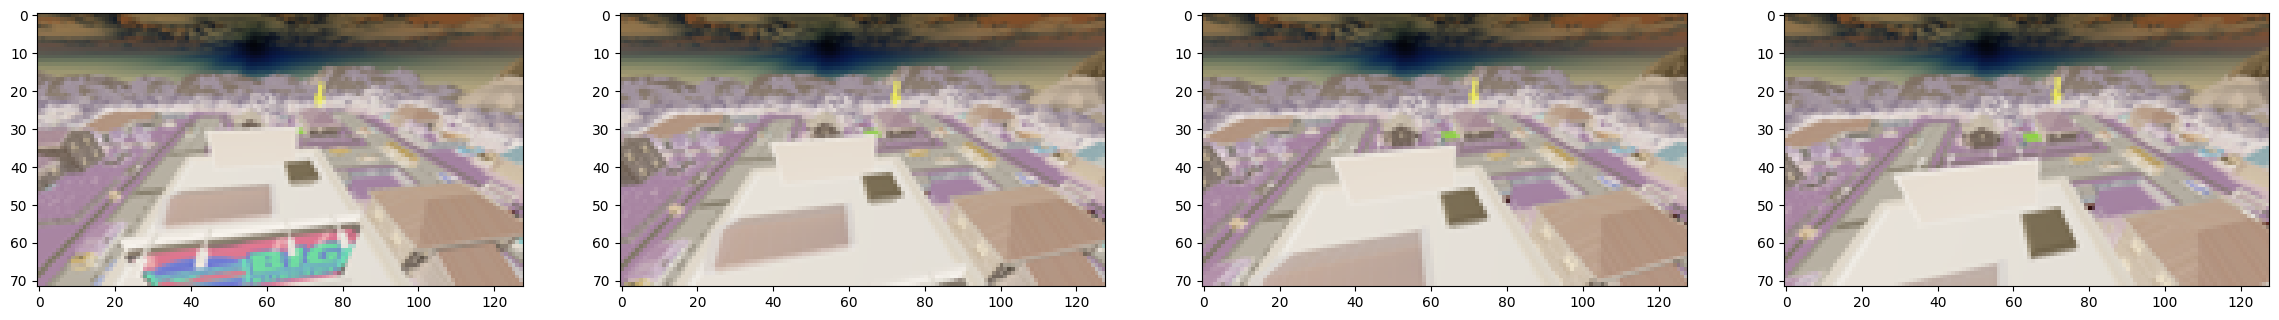

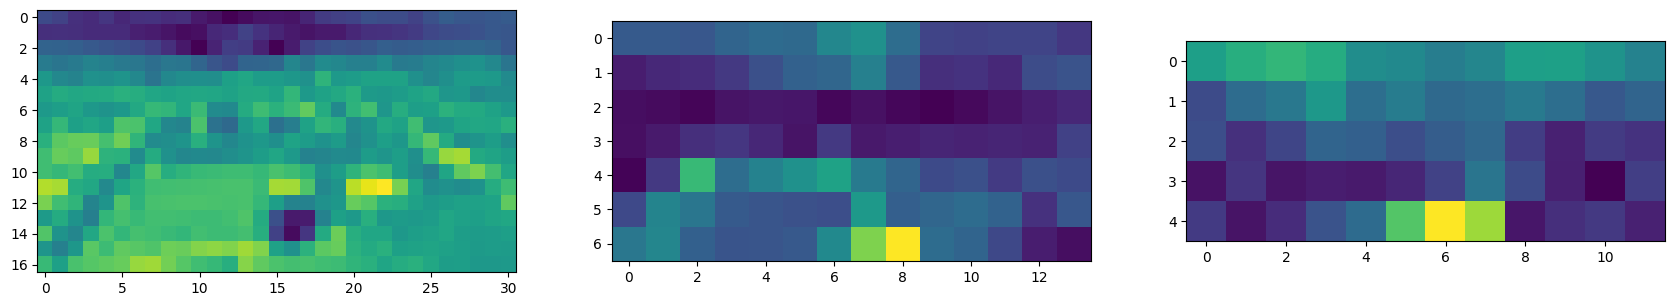

In [48]:
idx = 50

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(7.2*4, 12.8))
for ii in range(4):
    ax = axs[ii]
    img = input_[idx][3*ii:3*(ii+1)]
    ax.imshow(img.transpose(0,1).transpose(1,2))
    
fig, axs = plt.subplots(ncols=3, figsize=(21,7))
axs[0].imshow(conv1[idx].numpy().mean(axis=0))
axs[1].imshow(conv2[idx].numpy().mean(axis=0))
axs[2].imshow(conv3[idx].numpy().mean(axis=0))

check the parameter invariance

In [49]:
# network.head.conv1.weight == ckpt['network']['head.conv1.weight']

---

#### PCA

In [50]:
pca = PCA(n_components=200)

conv1

In [51]:
print(conv1.shape)
nsamples = conv1.shape[0]
nfeatures = np.prod(conv1.shape[1:])

torch.Size([1300, 32, 17, 31])


In [52]:
PCs = pca.fit_transform(conv1.reshape(nsamples,nfeatures))
PCs.shape

(1300, 200)

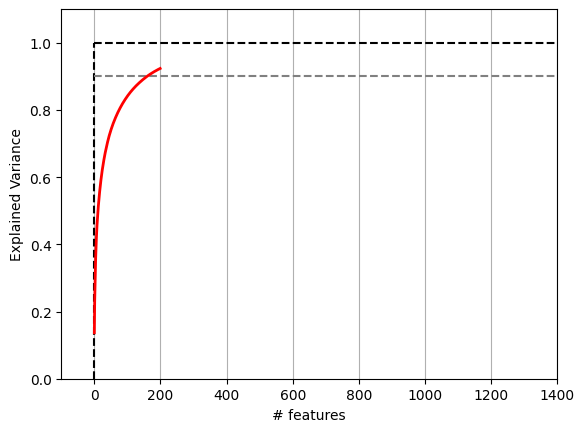

In [53]:
plt.hlines(y=1., xmin=0, xmax=2000, color='black', linestyles='--')
plt.vlines(x=0., ymin=-0, ymax=1, color='black', linestyles='--')
plt.hlines(y=0.9, xmin=0, xmax=2000, color='gray', linestyles='--')

plt.plot(np.cumsum(pca.explained_variance_ratio_), color='red', linewidth=2.)

plt.xlabel('# features')
plt.ylabel('Explained Variance')
plt.xlim(-100,1400)
plt.ylim(0,1.1)
plt.grid(axis='x')

---

In [104]:
## time shift 를 고려하여 추려낸, 분석 가능한 EPI index
indices = np.concatenate(list(idx_epi.values()))
print(indices.shape)
print(indices)

## 위 index들 외의 index들은 분석 불가능하므로, feature들을 0으로 둔다
tmp = np.zeros((TPs, pca.n_components))
print(tmp.shape)

## 얻어낸 index 에 맞게 PC들을 매칭하여 부분적인 X를 완성시킨다
tmp[indices] = PCs
X[shift] = tmp

(1285,)
[  10   11   12 ... 1385 1386 1387]
(1388, 200)


NameError: name 'PCs' is not defined

In [41]:
Xmat = np.ones([TPs,1])
Xmat = np.concatenate(
    [Xmat, X[5], X[5.5], X[6]],
    axis=1
)
Xmat.shape

KeyError: 5.5

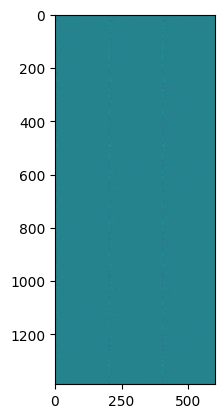

In [128]:
fig, ax = plt.subplots()
ax.imshow(Xmat)

---

#### make Xmat completely

In [30]:
nruns = 6
pca = PCA(n_components=200)

In [31]:
Xmat = np.ones([nruns,TPs,600+1])
for rr, run in enumerate(['Run%1d'%(ii+1) for ii in range(6)]):
    print(run, end='\r')
    X = {}
    for shift in np.arange(5,6.1,0.5):
        ## 서로 매칭가능한 list_png의 index 와 EPI 의 index
        idx_input, idx_epi = get_idx_input(run=run, shift=shift)
        
        for ii, (episode, indices) in enumerate(tqdm(idx_epi.items())):
            ## 해당 EPI index에 매칭되는 png의 index들
            tmp = idx_input[episode]

            ## 해당 RUN에 input으로 쓰일 모든 png fname 들
            if ii > 0:
                input_fname = np.concatenate(
                    [
                        input_fname,
                        list_png[run][tmp]
                    ],
                    axis=0
                )
            else:
                input_fname = list_png[run][tmp]

        ## (batch size of Run, 4)
        (batch, _) = input_fname.shape

        ## Actual input values to be entered into the network
        input_ = np.zeros((batch,12,72,128), dtype=np.uint8)
        
        for timepoint, fnames in enumerate(input_fname):
            ## 4 frames (1,72,128,3) 를 numpy 로 불러와서 쌓음
            tmp = np.stack(
                [np.asarray(Image.open(f)).reshape((1,72,128,3)) for f in fnames],
                axis=0
            )

            ## 이미지 전처리 (4, 1, 72, 128, 3) -> (12, 72, 128, 3)
            input_[timepoint] = state_processing(tmp)

        ## 이미지를 torch.tensor 로 변경
        input_ = torch.from_numpy(input_)
        
        ## 쌓은 frame 들을 network에 입력 (Forward)
        with torch.no_grad():
            output_ = network(input_.to(device))
        (mu, std, v), (conv1, conv2, conv3) = output_
        
        ## PCA
        nsamples = conv1.shape[0]
        nfeatures = np.prod(conv1.shape[1:])
        PCs = pca.fit_transform(conv1.reshape(nsamples,nfeatures))
        
        ## time shift 를 고려하여 추려낸, 분석 가능한 EPI index
        indices = np.concatenate(list(idx_epi.values()))
        
        ## 위 index들 외의 index들은 분석 불가능하므로, feature들을 0으로 둔다
        tmp = np.zeros((TPs, pca.n_components))

        ## 얻어낸 index 에 맞게 PC들을 매칭하여 부분적인 X를 완성시킨다
        tmp[indices] = PCs
        X[shift] = tmp
        
    Xmat[rr] = np.concatenate(
        [np.ones([TPs,1]), X[5], X[5.5], X[6]],
        axis=1
    )
Xmat.shape

100%|██████████| 65/65 [00:00<00:00, 26471.48it/s]


100%|██████████| 69/69 [00:00<00:00, 25711.35it/s]


100%|██████████| 73/73 [00:00<00:00, 26855.91it/s]


100%|██████████| 55/55 [00:00<00:00, 25036.54it/s]


100%|██████████| 57/57 [00:00<00:00, 28835.52it/s]


100%|██████████| 52/52 [00:00<00:00, 23364.09it/s]


(6, 1388, 601)

---

### fMRI data

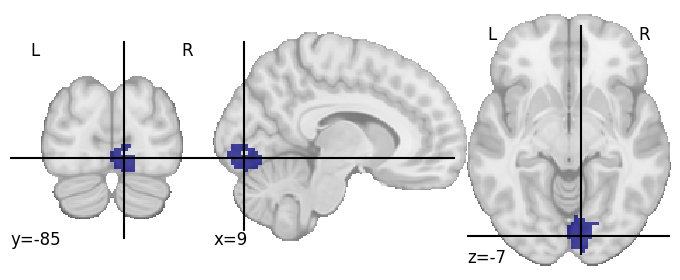

In [32]:
mask = join(dir_mask,'fan280/fan.roi.190.resampled.nii')
plotting.plot_roi(mask)

In [33]:
Y = masking.apply_mask(
    imgs = join(dir_fmri,'preproc_data/%s/errts.%s.volreg.tproject.nii'%(subj,subj))
    , mask_img = mask
)
Y = scaler.fit_transform(Y)
(_, nvoxels) = Y.shape
Y.shape

(8328, 301)

In [34]:
Y = Y.reshape(6,TPs,-1)
Y.shape

(6, 1388, 301)

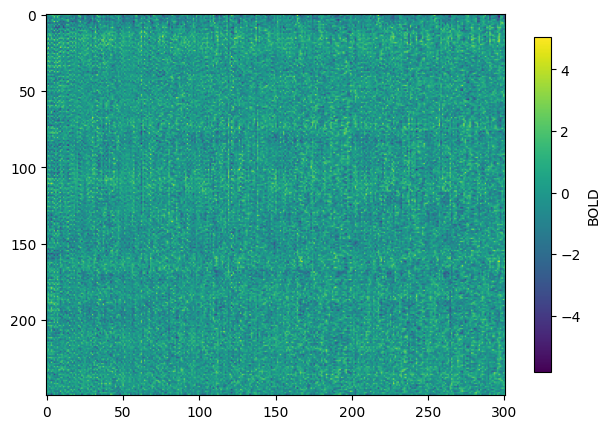

In [35]:
fig, ax = plt.subplots()
g = plt.imshow(Y[0,:250,:])
fig.colorbar(g, shrink=0.75, label='BOLD')
fig.tight_layout()

---

#### Ridge Regression

In [36]:
from himalaya.ridge import RidgeCV

In [37]:
print(Y.shape)
print(Xmat.shape)

(6, 1388, 301)
(6, 1388, 601)


In [39]:
clf = RidgeCV(alphas=[1, 10, 100])

In [53]:
tmp = clf.fit(
    np.concatenate([Xmat[ii] for ii in range(5)], axis=0),
    np.concatenate([Y[ii] for ii in range(5)], axis=0)
)
tmp

In [55]:
Y_pred = tmp.predict(Xmat[5])

In [60]:
corr = np.zeros(nvoxels)
for ii in range(nvoxels):
    a = Y[5][ii]
    b = Y_pred[ii]
    r, p = stats.pearsonr(a,b)
    corr[ii] = r

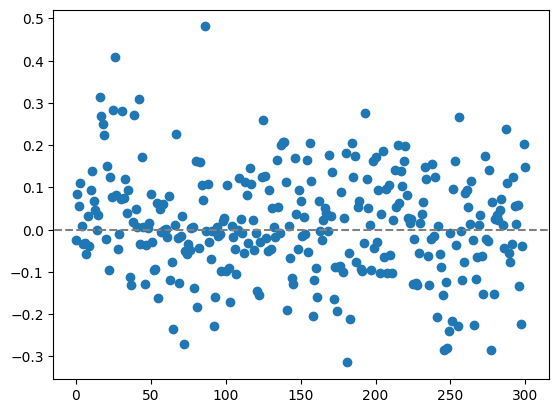

In [72]:
plt.scatter(range(nvoxels), corr)
plt.xlim(-0.05*nvoxels,nvoxels*(1.05))
plt.hlines(y=0, xmin=-nvoxels, xmax=2*nvoxels, color='gray', linestyle='--')

---

In [ ]:
def perform_encoding(pca_dir, fmri_dir, results_dir, sub, layer, ROI = 'WB', mode = 'val', visualize_results = True\
                     , batch_size=1000):
    if torch.cuda.is_available():
        use_gpu = True
    else:
        use_gpu = False

    ###### Load activations ##############
    train_activations, test_activations = get_activations(pca_dir, layer)
    ######################################

    ##### Load fMRI data #################
    fmri_train_all, voxel_mask = get_fmri(os.path.join(fmri_dir, track, subj),ROI)

    num_voxels = fmri_train_all.shape[1]
    ######################################


    #### Creating data splits ###############
    if mode == 'val':
        # Here as an example we use first 900 videos as training and rest of the videos as validation
        test_activations = train_activations[900:,:]
        train_activations = train_activations[:900,:]
        fmri_train = fmri_train_all[:900,:]
        fmri_test = fmri_train_all[900:,:]
        pred_fmri = np.zeros_like(fmri_test)
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_val.npy')
    else:
        fmri_train = fmri_train_all
        num_test_videos = 102
        pred_fmri = np.zeros((num_test_videos,num_voxels))
        pred_fmri_save_path = os.path.join(results_dir, ROI + '_test.npy')
    ######################################

    ######## Performing regression ################
    iter = 0

    while iter < num_voxels-batch_size:
        pred_fmri[:,iter:iter+batch_size] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
        iter = iter+batch_size
    pred_fmri[:,iter:] = predict_fmri_fast(train_activations,test_activations,fmri_train[:,iter:iter+batch_size], use_gpu = use_gpu)
    if mode == 'val':
        score = vectorized_correlation(fmri_test, pred_fmri)
        print("----------------------------------------------------------------------------")
        print("Mean correlation for ROI : ",ROI, "in ",sub," using ",layer, " is :", round(score.mean(), 6))
        ################################################

        nii_save_path =  os.path.join(results_dir, ROI + '_val.nii')
        ######## Result visualization ################
        if track == "full_track" and visualize_results:
            visual_mask_3D = np.zeros((78,93,71))
            visual_mask_3D[voxel_mask==1] = score
            brain_mask = '/content/example.nii'
            saveasnii(brain_mask, nii_save_path, visual_mask_3D)
            plotting.plot_glass_brain(nii_save_path, plot_abs=False,
                              title = 'Correlation for ' + sub + ' and ' + layer,
                              display_mode='lyr', colorbar=True,vmin=-1,vmax=1)

        ################################################

    np.save(pred_fmri_save_path, pred_fmri)

---

In [1]:
from himalaya.backend import set_backend

In [3]:
backend = set_backend('cupy')

---

# Compute the explainable variance

Before fitting any voxelwise model to fMRI responses, it is good practice to
quantify the amount of signal in the test set that can be predicted by an
encoding model. This quantity is called the *explainable variance*.

The measured signal can be decomposed into a sum of two components: the
stimulus-dependent signal and noise. If we present the same stimulus multiple
times and we record brain activity for each repetition, the stimulus-dependent
signal will be the same across repetitions while the noise will vary across
repetitions. In voxelwise modeling, the features used to model brain activity
are the same for each repetition of the stimulus. Thus, encoding models will
predict only the repeatable stimulus-dependent signal.

The stimulus-dependent signal can be estimated by taking the mean of brain
responses over repeats of the same stimulus or experiment. The variance of the
estimated stimulus-dependent signal, which we call the explainable variance, is
proportional to the maximum prediction accuracy that can be obtained by a
voxelwise encoding model in the test set.

Mathematically, let $y_i, i = 1 \dots N$ be the measured signal in a
voxel for each of the $N$ repetitions of the same stimulus and
$\bar{y} = \frac{1}{N}\sum_{i=1}^Ny_i$ the average brain response
across repetitions. For each repeat, we define the residual timeseries between
brain response and average brain response as $r_i = y_i - \bar{y}$. The
explainable variance (EV) is estimated as

\begin{align}\text{EV} = \frac{1}{N}\sum_{i=1}^N\text{Var}(y_i) - \frac{N}{N-1}\sum_{i=1}^N\text{Var}(r_i)\end{align}


In the literature, the explainable variance is also known as the *signal
power*.

In [ ]:
ncondition

Then, we compute the explainable variance for each voxel.

In [14]:
from voxelwise_tutorials.utils import explainable_variance

ev = explainable_variance(Y)
print("(n_voxels,) =", ev.shape)

(n_voxels,) = (113158,)


To better understand the concept of explainable variance, we can plot the
measured signal in a voxel with high explainable variance...

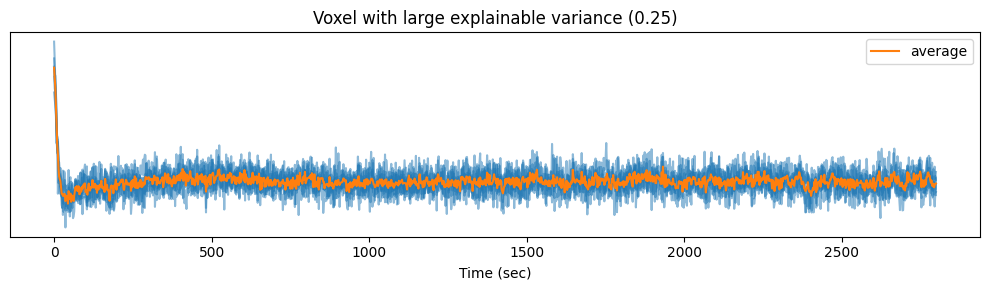

In [16]:
voxel_1 = np.argmax(ev)
time = np.arange(Y.shape[1]) * 2  # one time point every 2 seconds
plt.figure(figsize=(10, 3))
plt.plot(time, Y[:, :, voxel_1].T, color='C0', alpha=0.5)
plt.plot(time, Y[:, :, voxel_1].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with large explainable variance (%.2f)" % ev[voxel_1])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

... and in a voxel with low explainable variance.

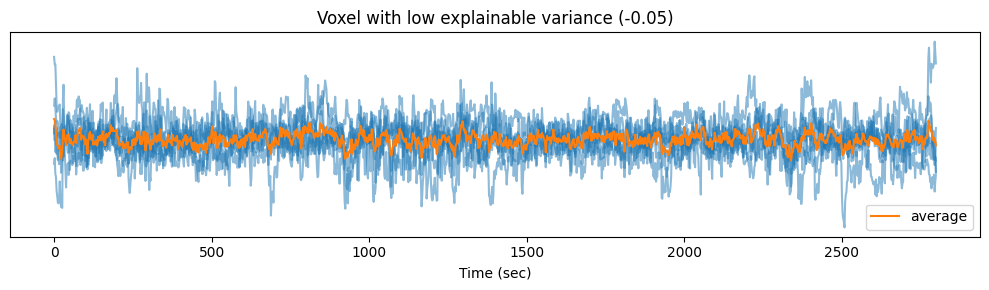

In [17]:
voxel_2 = np.argmin(ev)
plt.figure(figsize=(10, 3))
plt.plot(time, Y[:, :, voxel_2].T, color='C0', alpha=0.5)
plt.plot(time, Y[:, :, voxel_2].mean(0), color='C1', label='average')
plt.xlabel("Time (sec)")
plt.title("Voxel with low explainable variance (%.2f)" % ev[voxel_2])
plt.yticks([])
plt.legend()
plt.tight_layout()
plt.show()

We can also plot the distribution of explainable variance over voxels.

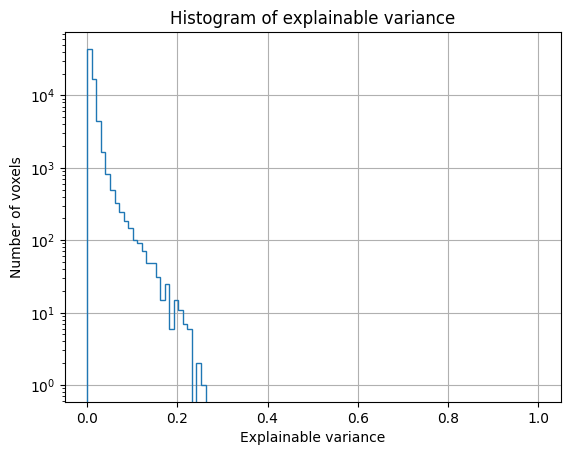

In [18]:
plt.hist(ev, bins=np.linspace(0, 1, 100), log=True, histtype='step')
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.grid('on')
plt.show()

---

pycortex

set up the environment variables for the pycortex

In [ ]:
import sklearn
sklearn.set_config(assume_finite=True)

---